In [1]:
import os
import tensorflow as tf

from lob.lob_gan import *

%load_ext autoreload
%autoreload 2

imported at 2025-04-09 19:31:08.879023


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
RAW_DATA = pd.read_parquet('lob/BTCUSDT-lob.parq', engine='pyarrow')
assert RAW_DATA.notna().all(axis=None)
RAW_DATA

,E,T,U,u,pu,b0p,b1p,b2p,b3p,b4p,...,a0q,a1q,a2q,a3q,a4q,a5q,a6q,a7q,a8q,a9q
0,1739868923498,1739868923498,6783640382776,6783640393900,6783640382281,95179.9,95179.5,95179.0,95178.7,95178.0,...,8.937,0.190,0.036,0.002,0.095,0.002,0.002,0.002,0.158,0.002
1,1739868923614,1739868923610,6783640396586,6783640404328,6783640393900,95179.9,95179.5,95179.0,95178.7,95178.0,...,8.953,0.154,0.002,0.095,0.002,0.002,0.002,0.158,0.002,0.002
2,1739868923724,1739868923721,6783640405138,6783640420666,6783640404328,95179.9,95179.5,95179.0,95178.7,95178.0,...,8.953,0.154,0.042,0.002,0.095,0.002,0.002,0.002,0.158,0.004
3,1739868923827,1739868923821,6783640421340,6783640434389,6783640420666,95179.9,95179.5,95179.0,95178.7,95178.0,...,8.953,0.154,0.042,0.002,0.095,0.002,0.002,0.002,0.158,0.004
4,1739868923948,1739868923946,6783640436896,6783640445572,6783640434389,95179.9,95179.5,95179.0,95178.7,95178.0,...,8.957,0.154,0.042,0.002,0.095,0.002,0.002,0.002,0.158,0.004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189755,1739937377488,1739937377486,6791359179849,6791359186272,6791359179542,95733.3,95733.2,95733.1,95733.0,95732.9,...,0.884,0.007,0.002,0.014,0.050,0.002,0.002,0.002,0.002,0.010
189756,1739937377596,1739937377595,6791359186752,6791359194092,6791359186272,95733.3,95733.2,95733.1,95733.0,95732.9,...,1.438,0.007,0.002,0.014,0.050,0.002,0.002,0.002,0.002,0.010
189757,1739937377698,1739937377697,6791359194379,6791359202977,6791359194092,95733.3,95733.2,95733.1,95733.0,95732.9,...,5.604,0.007,0.002,0.014,0.002,0.050,0.002,0.002,0.002,0.002
189758,1739937377806,1739937377806,6791359203537,6791359209077,6791359202977,95733.3,95733.2,95733.1,95733.0,95732.9,...,5.453,0.007,0.002,0.014,0.002,0.050,0.002,0.002,0.002,0.002


In [4]:
%%time

SAMPLE_SIZE = min(len(RAW_DATA), Configs().sample_size)
BATCH_SIZE = SAMPLE_SIZE // Configs().n_batches

LOB_DATASET = create_dataset(RAW_DATA, sample_size=SAMPLE_SIZE, batch_size=BATCH_SIZE)

CPU times: user 22 ms, sys: 9.98 ms, total: 32 ms
Wall time: 35 ms


{'neg_qty_sum': 0.0,
 'neg_qty_count': 0.0,
 'neg_diff_sum': 0.0,
 'neg_diff_count': 0.0}

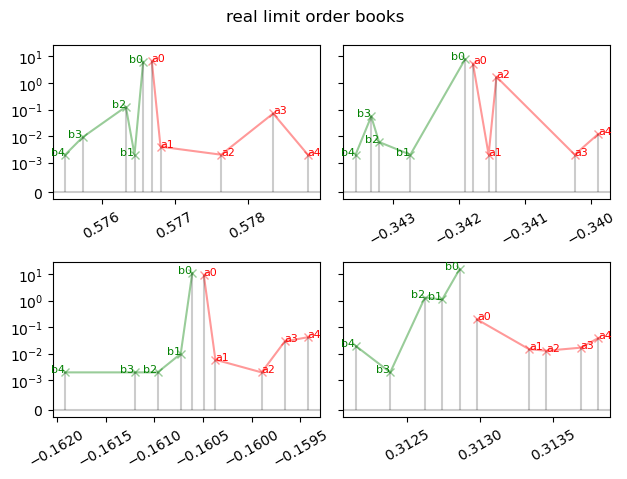

CPU times: user 1.06 s, sys: 86.4 ms, total: 1.15 s
Wall time: 507 ms


In [5]:
%%time

for i, batch in enumerate(LOB_DATASET):
    ss = calculate_sample_stats(batch)
    display(ss)
    f, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, sharey=True)
    f.suptitle('real limit order books')
    plot_lob_snapshot(batch[0], ax0)
    plot_lob_snapshot(batch[1], ax1)
    plot_lob_snapshot(batch[2], ax2)
    plot_lob_snapshot(batch[3], ax3)
    plt.tight_layout()
    plt.show()
    break

100%|███████████████████| 64/64 [01:05<00:00,  1.02s/it]

Training completed in 1.09 minutes
plot_training_history


,disc_loss,real_loss,fake_loss,gen_loss,adv_loss,fm_loss,real_prob,fake_prob,neg_qty_sum,neg_qty_count,neg_diff_sum,neg_diff_count
0,1.872436,1.036949,0.835487,0.621948,0.621948,0.0,0.465138,0.551341,1.302932,3.6752,15.148128,19.645599
1,1.272612,0.474300,0.798313,0.657459,0.657459,0.0,0.661283,0.534212,1.356781,3.5208,15.825306,19.579199
2,0.983135,0.257942,0.725193,0.733222,0.733222,0.0,0.790515,0.499402,1.435714,3.3256,16.387350,19.453600
3,0.838598,0.190426,0.648173,0.826169,0.826169,0.0,0.839932,0.460397,1.528010,3.1232,16.994774,19.591200
4,0.759119,0.165213,0.593906,0.902124,0.902124,0.0,0.858923,0.431306,1.625082,2.9288,17.831730,19.984800
...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.059138,0.049433,0.009705,8.661130,8.661130,0.0,0.962634,0.008783,19.621061,4.1072,48.172207,25.007200
60,0.048863,0.042069,0.006794,9.211404,9.211404,0.0,0.968008,0.006273,21.308277,4.0968,48.598850,24.261599
61,0.040919,0.036207,0.004712,9.797668,9.797668,0.0,0.972341,0.004424,22.950155,4.1128,49.404530,23.640799
62,0.034670,0.031469,0.003201,10.434837,10.434837,0.0,0.975879,0.003048,24.632959,4.1536,50.606819,23.007200


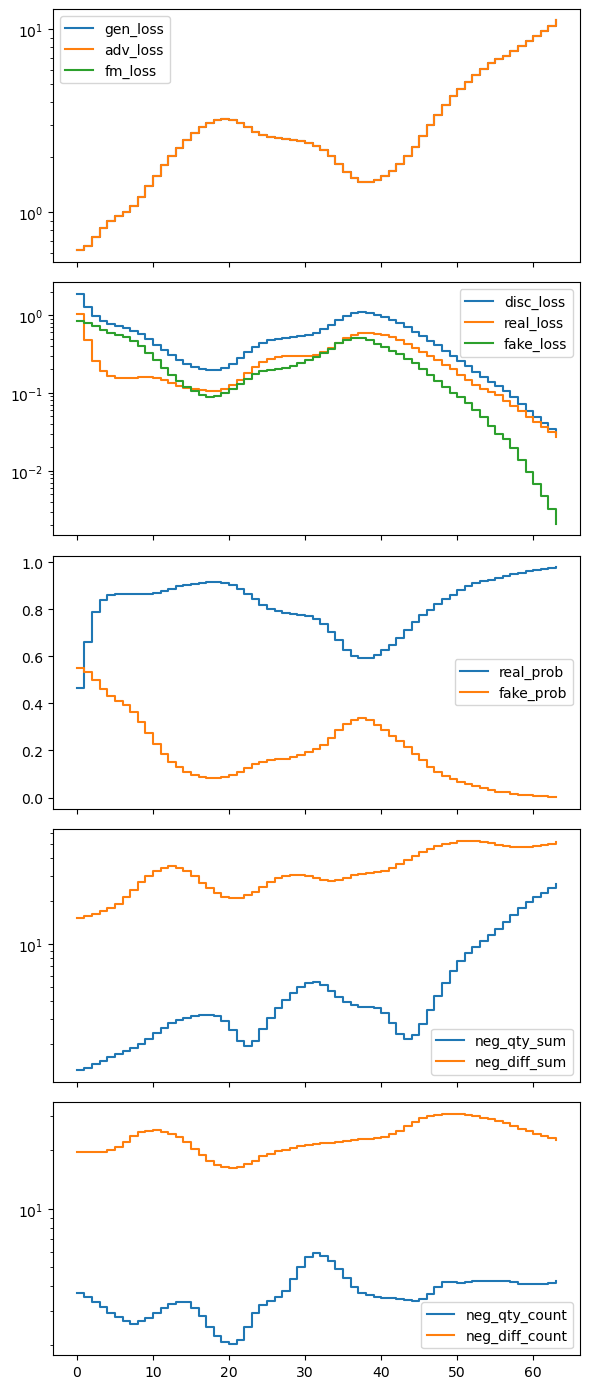

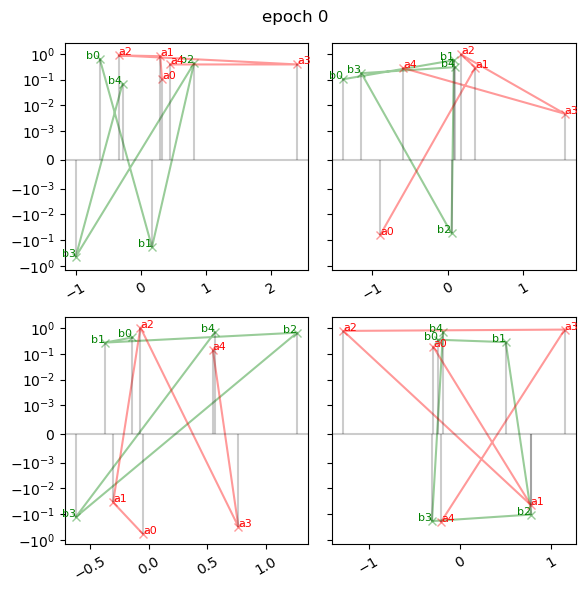

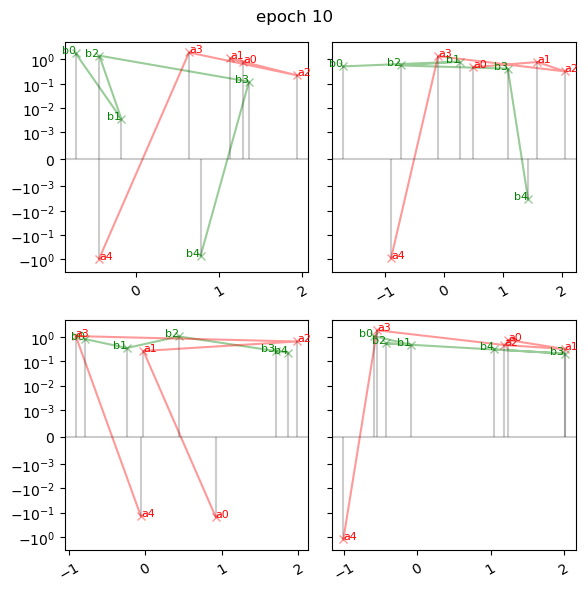

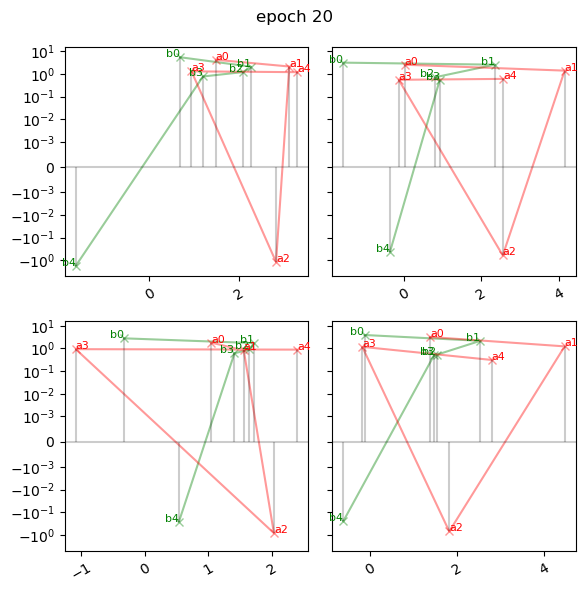

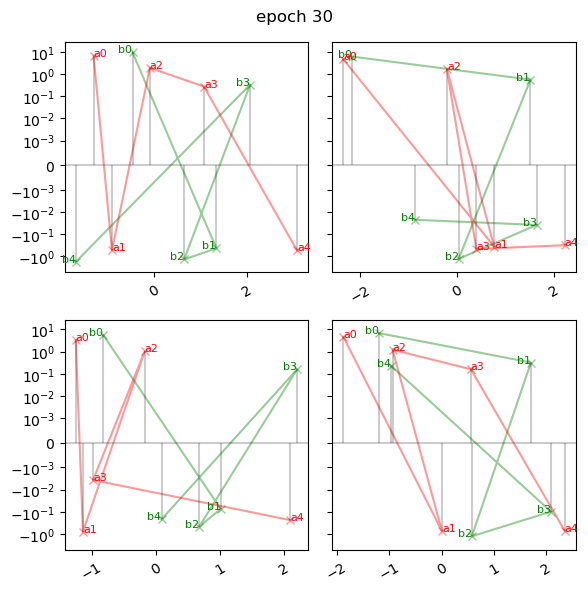

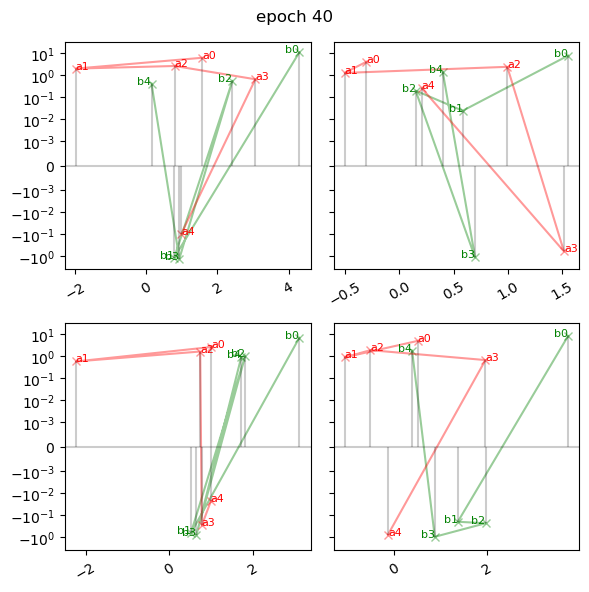

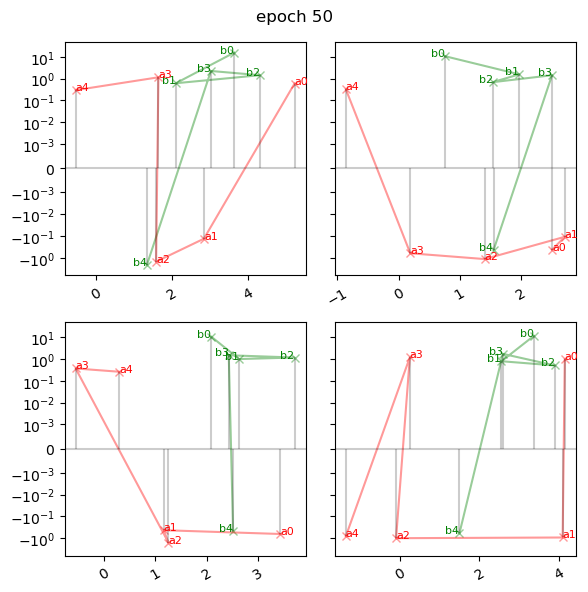

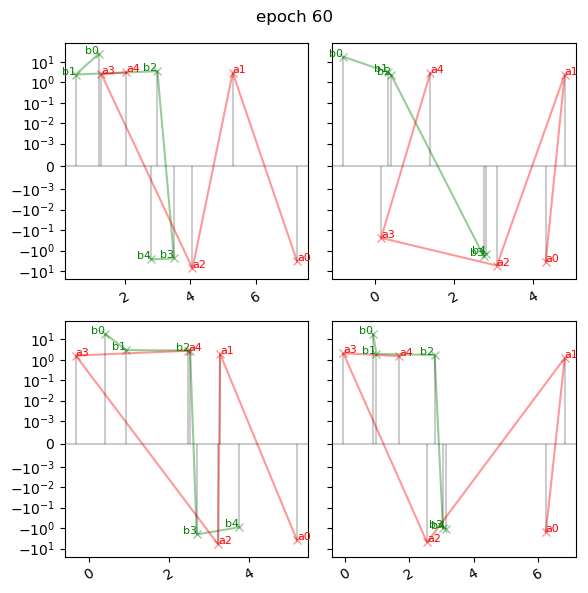

In [6]:
gan = ImprovedGAN(RAW_DATA, Configs(fm_multiplier=0.0))
generated_lobs, metrics = gan.train()
plot_training_history(metrics)
plot_lobs(generated_lobs)

100%|███████████████████| 64/64 [01:06<00:00,  1.04s/it]

Training completed in 1.11 minutes
plot_training_history


,disc_loss,real_loss,fake_loss,gen_loss,adv_loss,fm_loss,real_prob,fake_prob,neg_qty_sum,neg_qty_count,neg_diff_sum,neg_diff_count
0,1.830188,1.040973,0.789215,3303.286148,0.654769,3302.631378,0.464050,0.531662,0.932235,3.0688,11.925185,18.609600
1,1.193677,0.488755,0.704922,2713.381226,0.735754,2712.645462,0.653943,0.492734,0.666502,2.4504,9.781393,17.162399
2,0.889536,0.275353,0.614183,2221.006035,0.841236,2220.164803,0.778982,0.446645,0.486292,1.9840,8.015895,15.724799
3,0.726469,0.208503,0.517967,1821.529922,0.979107,1820.550827,0.828375,0.393151,0.363643,1.6440,6.590236,14.264000
4,0.609193,0.181173,0.428020,1502.987640,1.142117,1501.845520,0.850760,0.338493,0.278317,1.3576,5.461245,12.818399
...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.024394,0.016458,0.007936,35.814528,7.492617,28.321911,0.985168,0.007494,0.006919,0.1256,0.063531,0.594400
60,0.024323,0.016498,0.007824,35.437075,7.580851,27.856224,0.985140,0.007378,0.006852,0.1216,0.061358,0.582400
61,0.024266,0.016555,0.007711,35.073359,7.670336,27.403023,0.985099,0.007260,0.006806,0.1208,0.059285,0.564800
62,0.024216,0.016621,0.007595,34.721531,7.761192,26.960340,0.985054,0.007141,0.006703,0.1240,0.057335,0.543200


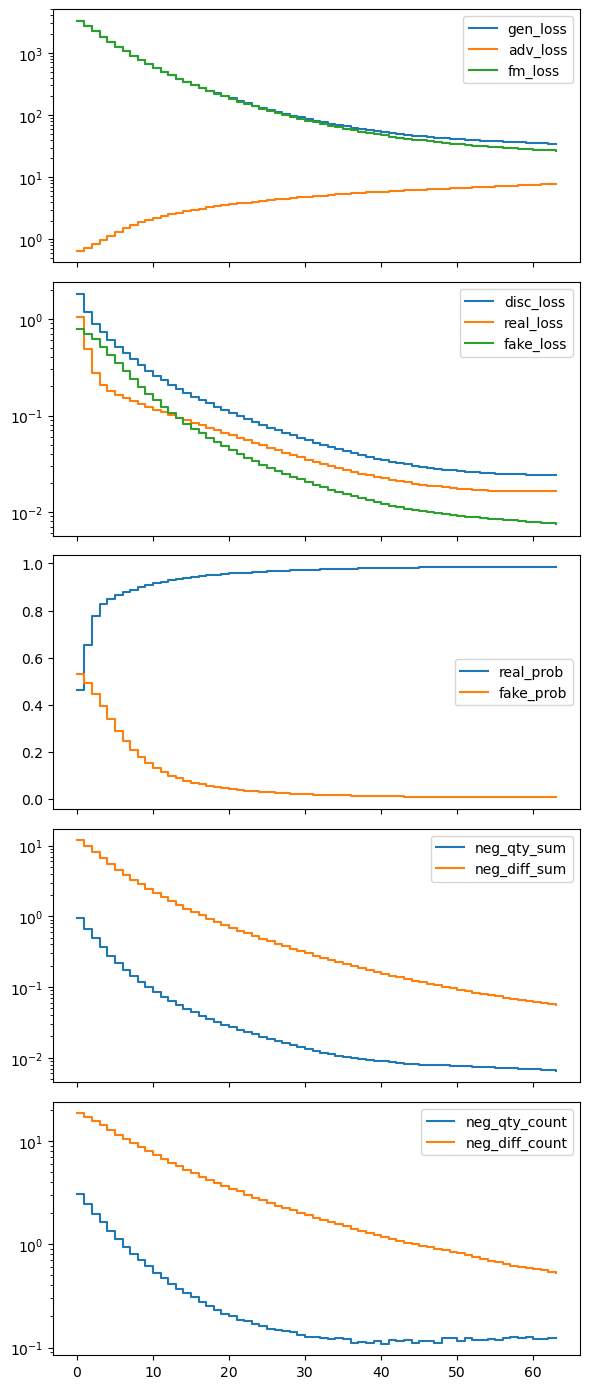

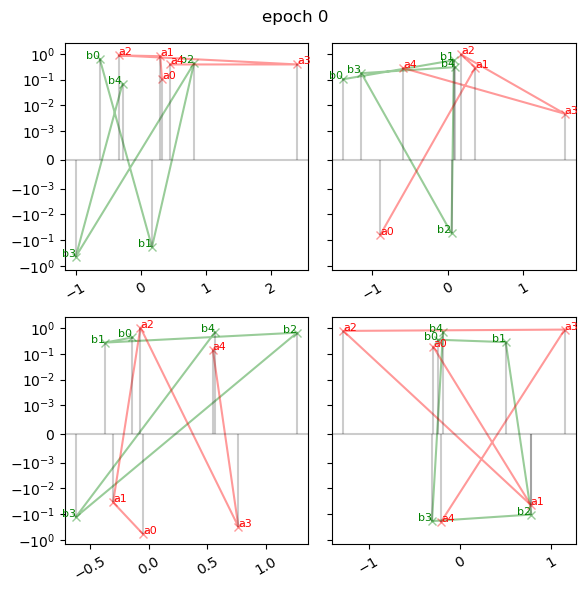

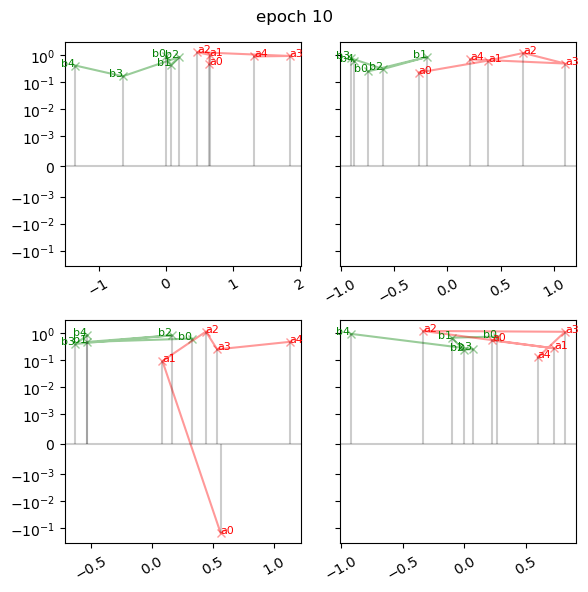

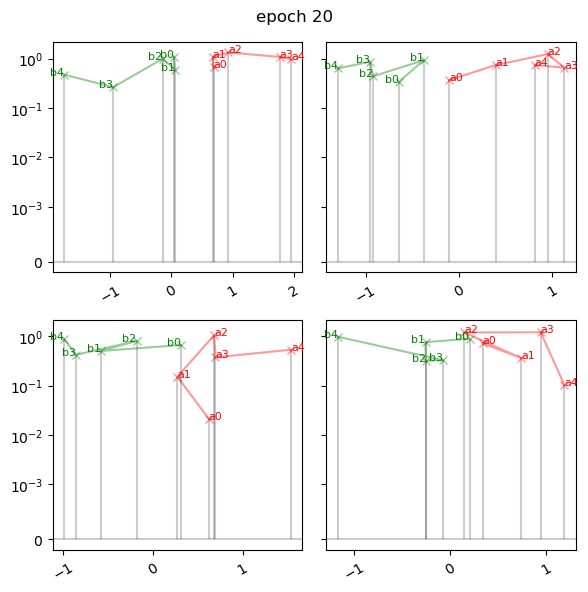

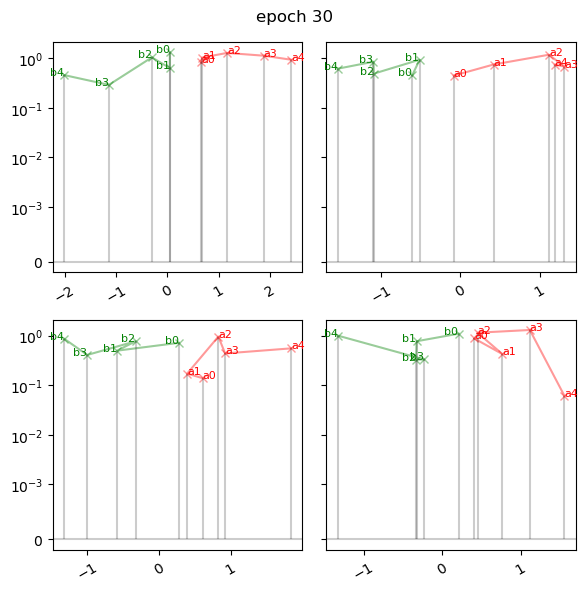

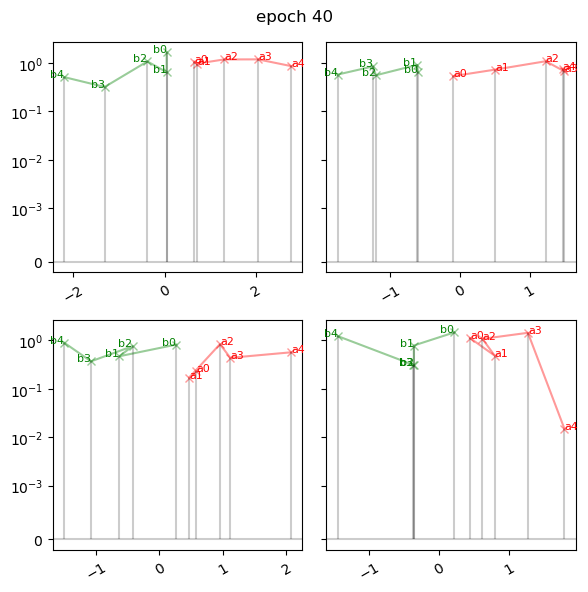

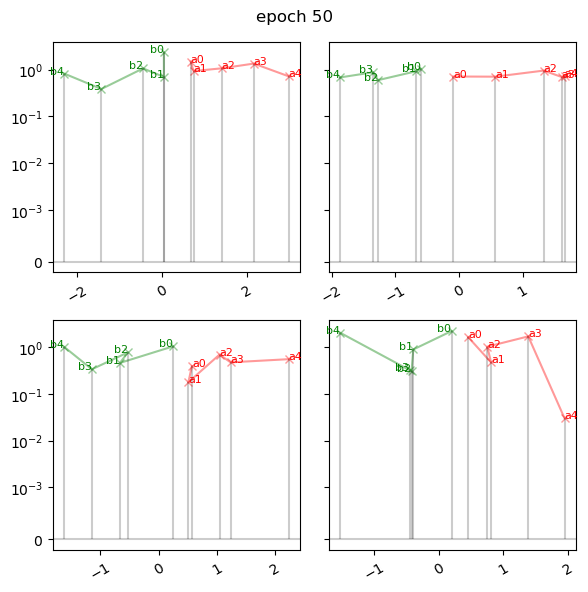

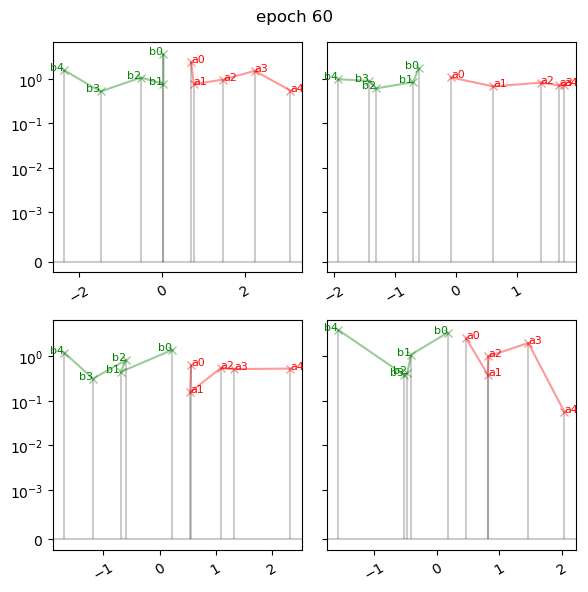

In [7]:
gan = ImprovedGAN(RAW_DATA, Configs(fm_multiplier=0.1))
generated_lobs, metrics = gan.train()
plot_training_history(metrics)
plot_lobs(generated_lobs)